# PubChem API in Python

By Avery Fernandez

PubChem provides programmatic access to chemical data and bioactivity information from the National Center for Biotechnology Information (NCBI), enabling efficient retrieval and analysis of chemical structures, identifiers, properties, and associated biological activities.

Please see the following resources for more information on API usage:
- Documentation
    - <a href="https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access" target="_blank">PubChem Programmatic Access</a>
    - <a href="https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest" target="_blank">PUG-REST API Documentation</a>
- Terms
    - <a href="https://www.ncbi.nlm.nih.gov/home/about/policies/" target="_blank">NCBI Policies and Disclaimers</a>
- Data Reuse
    - <a href="https://www.ncbi.nlm.nih.gov/home/about/policies/" target="_blank">NCBI Copyright Information</a>

_**NOTE:**_ The PubChem limits requests to a maximum of 5 requests per second.

*These recipe examples were tested on April 9, 2025.*

**Attribution:** This tutorial was adapted from supporting information in:

**Scalfani, V. F.**; Ralph, S. C. Alshaikh, A. A.; Bara, J. E. Programmatic Compilation of Chemical Data and Literature From PubChem Using Matlab. *Chemical Engineering Education*, **2020**, *54*, 230. https://doi.org/10.18260/2-1-370.660-115508 and https://github.com/vfscalfani/MATLAB-cheminformatics

## Setup

### Import Libraries

The following external libraries need to be installed into your enviornment to run the code examples in this tutorial:
* <a href="https://github.com/psf/requests" target="_blank">requests</a>
* <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
* <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>

We import the libraries used in this tutorial below:

In [1]:
import requests
from pprint import pprint
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. PubChem Similarity

### Get Compound Image

We can search for a compound and display an image, for example: 1-Butyl-3-methyl-imidazolium; CID = 2734162

In [2]:
# Request PNG from PubChem and save file
base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/"
compoundID = "2734162"

try:
    response = requests.get(base_url + "cid/" + compoundID + "/PNG")
    response.raise_for_status()
    img = response.content
    with open(f"{compoundID}.png", "wb") as out:
        out.write(img)
except requests.exceptions.RequestException as e:
    print(f"Error fetching PNG for CID {compoundID}: {e}")

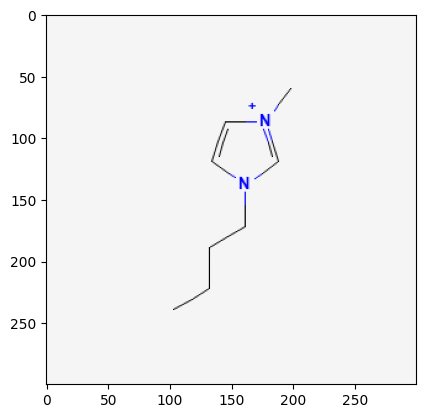

In [3]:
# Display compound PNG with Matplotlib
img = mpimg.imread(f"{compoundID}.png")
plt.imshow(img)
plt.show()

### Retrieve InChI and SMILES

In [4]:
properties = ["IsomericSMILES", "InChI"]
try:
    response = requests.get(
        base_url + "cid/" + compoundID + f"/property/{','.join(properties)}/JSON"
    )
    response.raise_for_status()
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Error fetching properties for CID {compoundID}: {e}")
    data = None

if data:
    pprint(data)

{'PropertyTable': {'Properties': [{'CID': 2734162,
                                   'InChI': 'InChI=1S/C8H15N2/c1-3-4-5-10-7-6-9(2)8-10/h6-8H,3-5H2,1-2H3/q+1',
                                   'IsomericSMILES': 'CCCCN1C=C[N+](=C1)C'}]}}


In [5]:
# Extract InChI
if data:
    print("Extracted InChI:")
    print(data["PropertyTable"]["Properties"][0]["InChI"])

Extracted InChI:
InChI=1S/C8H15N2/c1-3-4-5-10-7-6-9(2)8-10/h6-8H,3-5H2,1-2H3/q+1


In [6]:
# Extract Isomeric SMILES
if data:
    print("Extracted Isomeric SMILES:")
    print(data["PropertyTable"]["Properties"][0]["IsomericSMILES"])

Extracted Isomeric SMILES:
CCCCN1C=C[N+](=C1)C


### Perform a Similarity Search

We will use the PubChem API to perform a Fingerprint Tanimoto Similarity Search (SS).

(2D Tanimoto threshold 95% to 1-Butyl-3-methyl-imidazolium; CID = 2734162)

In [7]:
try:
    response = requests.get(
        base_url + "fastsimilarity_2d/cid/" + compoundID + "/cids/JSON?Threshold=95"
    )
    response.raise_for_status()
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Error fetching similar compounds for CID {compoundID}: {e}")
    data = None

if data:
    id_list = data["IdentifierList"]["CID"]
else:
    id_list = []

In the above request value, you can adjust to the desired Tanimoto threshold (i.e., 97, 90, etc.)

In [8]:
len(id_list)

293

In [9]:
# display first 25
id_list[0:25]

[61347,
 529334,
 2734161,
 118785,
 12971008,
 2734162,
 11171745,
 11424151,
 11448496,
 304622,
 2734236,
 11160028,
 20148470,
 11245926,
 87560886,
 87754289,
 2734168,
 5245884,
 53384410,
 87942618,
 4183883,
 10313448,
 10537570,
 11788435,
 15557008]

### Retrieve Identifier and Property Data

Get the following data for the retrieved CIDs (idList): InChI, Isomeric SMILES, MW, Heavy Atom Count, Rotable Bond Count, and Charge

In [10]:
compoundDictionary = []
properties = ["InChI", "IsomericSMILES", "MolecularWeight", 
              "HeavyAtomCount", "RotatableBondCount", "Charge"]

for cid in id_list:
    try:
        response = requests.get(
            base_url + "cid/" + str(cid) + f"/property/{','.join(properties)}/JSON"
        )
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        compoundDictionary.append(data["PropertyTable"]["Properties"][0])
    except requests.exceptions.RequestException as e:
        print(f"Error fetching properties for CID {cid}: {e}")

In [11]:
len(compoundDictionary)

293

In [12]:
pprint(compoundDictionary[0:3])

[{'CID': 61347,
  'Charge': 0,
  'HeavyAtomCount': 9,
  'InChI': 'InChI=1S/C7H12N2/c1-2-3-5-9-6-4-8-7-9/h4,6-7H,2-3,5H2,1H3',
  'IsomericSMILES': 'CCCCN1C=CN=C1',
  'MolecularWeight': '124.18',
  'RotatableBondCount': 3},
 {'CID': 529334,
  'Charge': 0,
  'HeavyAtomCount': 10,
  'InChI': 'InChI=1S/C8H14N2/c1-2-3-4-6-10-7-5-9-8-10/h5,7-8H,2-4,6H2,1H3',
  'IsomericSMILES': 'CCCCCN1C=CN=C1',
  'MolecularWeight': '138.21',
  'RotatableBondCount': 4},
 {'CID': 2734161,
  'Charge': 0,
  'HeavyAtomCount': 11,
  'InChI': 'InChI=1S/C8H15N2.ClH/c1-3-4-5-10-7-6-9(2)8-10;/h6-8H,3-5H2,1-2H3;1H/q+1;/p-1',
  'IsomericSMILES': 'CCCCN1C=C[N+](=C1)C.[Cl-]',
  'MolecularWeight': '174.67',
  'RotatableBondCount': 3}]


### Data Table

We can display the dictionary as a data table, but we will only do this for the first 25:

In [13]:
# numbers in print statement indicate amount of space used
print ("{:<10} {:<8} {:<16} {:<25} {:<40} {:<18} {:<4} ".format("CID", "Charge", 
        "HeavyAtomCount", "InChI", "IsomericSMILES", "MolecularWeight", "RotatableBondCount"))
for compound in compoundDictionary[0:25]:
    cid = compound["CID"]
    charge = compound["Charge"]
    heavyAtom = compound["HeavyAtomCount"]
    # only display first 30 characters of InChI
    inchi = compound["InChI"][0:20] + "..." 
    isomeric = compound["IsomericSMILES"]
    molecular = compound["MolecularWeight"]
    rotatable = compound["RotatableBondCount"]
    print ("{:<10} {:<8} {:<16} {:<25} {:<40} {:<18} {:<4} ".format(cid, charge, heavyAtom,
                                                    inchi, isomeric, molecular, rotatable))

CID        Charge   HeavyAtomCount   InChI                     IsomericSMILES                           MolecularWeight    RotatableBondCount 
61347      0        9                InChI=1S/C7H12N2/c1-...   CCCCN1C=CN=C1                            124.18             3    
529334     0        10               InChI=1S/C8H14N2/c1-...   CCCCCN1C=CN=C1                           138.21             4    
2734161    0        11               InChI=1S/C8H15N2.ClH...   CCCCN1C=C[N+](=C1)C.[Cl-]                174.67             3    
118785     0        8                InChI=1S/C6H10N2/c1-...   CCCN1C=CN=C1                             110.16             2    
12971008   0        10               InChI=1S/C7H13N2.HI/...   CCCN1C=C[N+](=C1)C.[I-]                  252.10             2    
2734162    1        10               InChI=1S/C8H15N2/c1-...   CCCCN1C=C[N+](=C1)C                      139.22             3    
11171745   0        15               InChI=1S/C8H15N2.C2N...   CCCCN1C=C[N+](=C1)C.

### Retrieve Images of Compounds from Similarity Search

61347


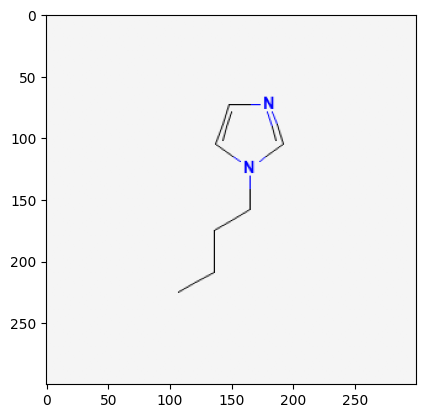

529334


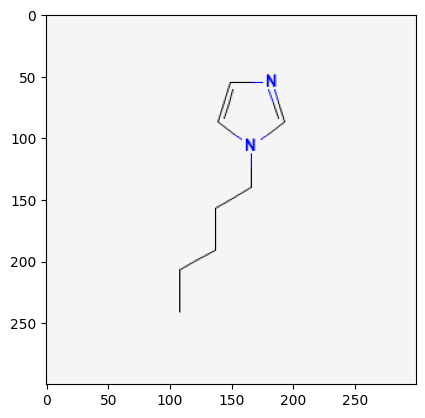

2734161


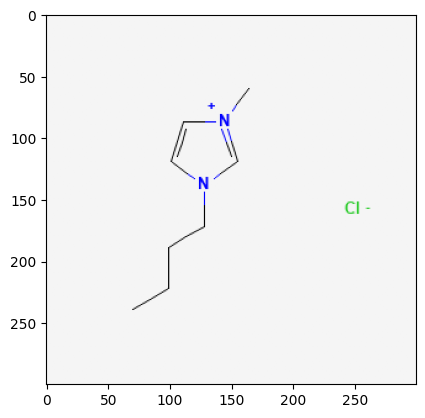

118785


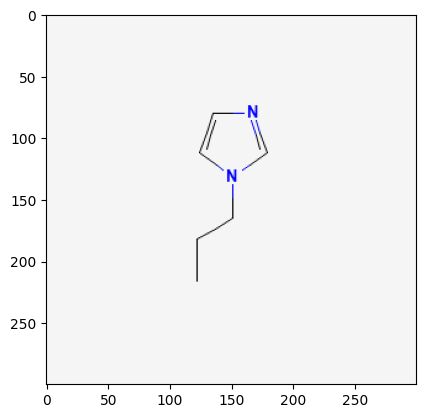

12971008


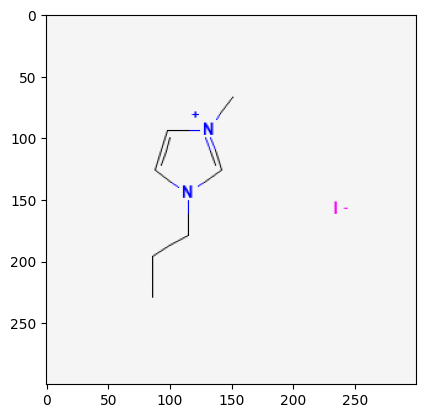

In [14]:
# we will only do this for the first five:
for cid in id_list[0:5]:
    try:
        response = requests.get(base_url + "cid/" + str(cid) + "/PNG")
        sleep(.25)
        response.raise_for_status()
        img = response.content
        with open(f"{cid}.png", "wb") as out:
            out.write(img)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching PNG for CID {cid}: {e}")
        continue

    print(cid)
    img = mpimg.imread(str(cid) + ".png")
    plt.imshow(img)
    plt.show()

## 2. PubChem SMARTS Search

Search for chemical structures from a SMARTS substructure query.

### Define SMARTS Queries

View pattern syntax at <a href="https://smarts.plus/" target="_blank">SMARTSPlus</a>.

Note: These are vinyl imidazolium substructure searches

In [ ]:
smartsQ = [
    "[CR0H2][n+]1[cH1][cH1]n([CR0H1]=[CR0H2])[cH1]1",
    "[CR0H2][n+]1[cH1][cH1]n([CR0H2][CR0H1]=[CR0H2])[cH1]1",
    "[CR0H2][n+]1[cH1][cH1]n([CR0H2][CR0H2][CR0H1]=[CR0H2])[cH1]1"
]

Add your own SMARTS queries to customize. You can add as many as desired within a list

### Perform a SMARTS query search

In [16]:
combinedList = []
for smarts in smartsQ:
    try:
        response = requests.get(base_url + "fastsubstructure/smarts/" + smarts + "/cids/JSON")
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        combinedList += data["IdentifierList"]["CID"]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching substructure for SMARTS {smarts}: {e}")
        request = None

In [17]:
len(combinedList)

945

In [18]:
pprint(combinedList[0:25]) # display 25

[2881855,
 23724184,
 2881236,
 2881558,
 2881232,
 2881324,
 2881449,
 2881640,
 24766550,
 87327009,
 87560886,
 87575063,
 121235111,
 2881597,
 2881807,
 23724198,
 132274871,
 1552916,
 1912201,
 2264809,
 46178576,
 86657882,
 129850195,
 129852976,
 129853221]


### Retrieve Identifier and Property Data

In [19]:
smartsList = []
properties = ["InChI", "IsomericSMILES", "MolecularWeight", 
              "IUPACName", "HeavyAtomCount", "CovalentUnitCount", "Charge"]
# demo for first 5 CIDs
for cid in combinedList[0:5]: 
    try:
        response = requests.get(
            base_url + "cid/" + str(cid) + f"/property/{','.join(properties)}/JSON"
        )
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        smartsList.append(data["PropertyTable"]["Properties"][0])
    except requests.exceptions.RequestException as e:
        print(f"Error fetching properties for CID {cid}: {e}")

pprint(smartsList[0:3])

[{'CID': 2881855,
  'Charge': 0,
  'CovalentUnitCount': 2,
  'HeavyAtomCount': 21,
  'IUPACName': '1-(3,4-dimethoxyphenyl)-2-(3-ethenylimidazol-1-ium-1-yl)ethanone;bromide',
  'InChI': 'InChI=1S/C15H17N2O3.BrH/c1-4-16-7-8-17(11-16)10-13(18)12-5-6-14(19-2)15(9-12)20-3;/h4-9,11H,1,10H2,2-3H3;1H/q+1;/p-1',
  'IsomericSMILES': 'COC1=C(C=C(C=C1)C(=O)C[N+]2=CN(C=C2)C=C)OC.[Br-]',
  'MolecularWeight': '353.21'},
 {'CID': 23724184,
  'Charge': 0,
  'CovalentUnitCount': 2,
  'HeavyAtomCount': 17,
  'IUPACName': '1-(5-bromothiophen-2-yl)-2-(3-ethenylimidazol-1-ium-1-yl)ethanone;bromide',
  'InChI': 'InChI=1S/C11H10BrN2OS.BrH/c1-2-13-5-6-14(8-13)7-9(15)10-3-4-11(12)16-10;/h2-6,8H,1,7H2;1H/q+1;/p-1',
  'IsomericSMILES': 'C=CN1C=C[N+](=C1)CC(=O)C2=CC=C(S2)Br.[Br-]',
  'MolecularWeight': '378.08'},
 {'CID': 2881236,
  'Charge': 0,
  'CovalentUnitCount': 2,
  'HeavyAtomCount': 19,
  'IUPACName': '1-(3,4-dichlorophenyl)-2-(3-ethenylimidazol-1-ium-1-yl)ethanone;bromide',
  'InChI': 'InChI=1S/C13H11Cl2N

### Retrieve Images of CID Compounds from SMARTS Search

2881855


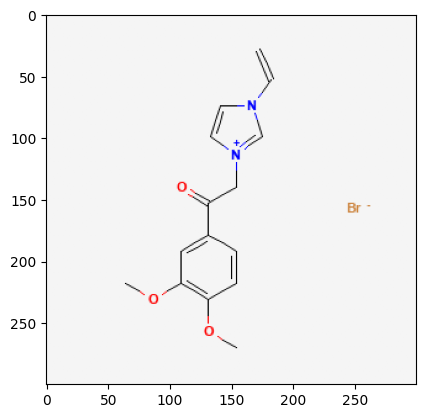

23724184


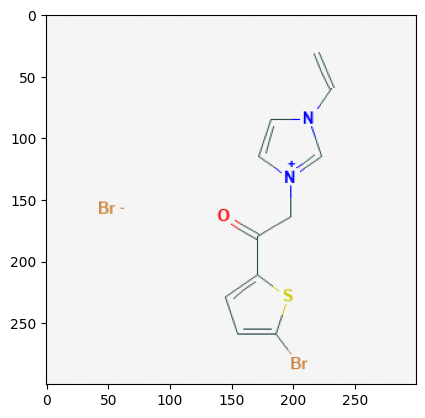

2881236


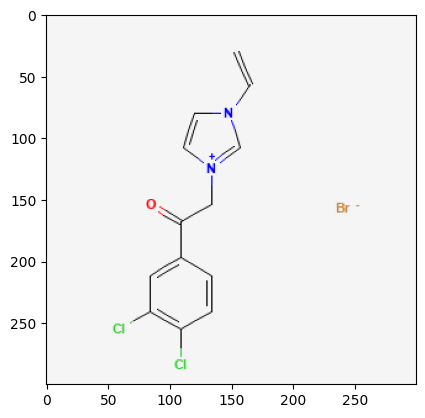

2881558


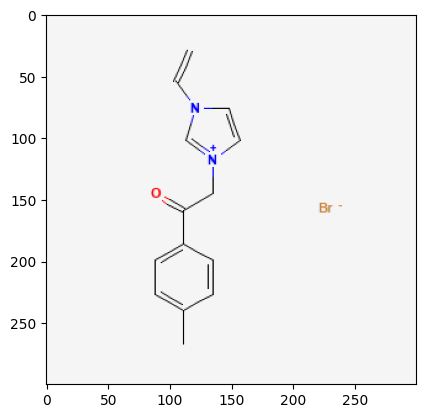

2881232


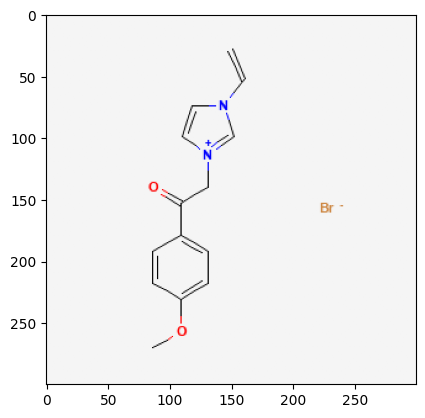

In [20]:
for cid in combinedList[0:5]:
    try:
        response = requests.get(base_url + "cid/" + str(cid) + "/PNG")
        sleep(.25)
        response.raise_for_status()
        img = response.content
        with open(f"{cid}.png", "wb") as out:
            out.write(img)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching PNG for CID {cid}: {e}")
        continue

    # display image
    pprint(cid)
    img = mpimg.imread(str(cid) + ".png")
    plt.imshow(img)
    plt.show()